# Build a Convolutional Neural Network (CNN) model to classify images from a given dataset into predefined categories/classes.



### Importing general dependencies

In [102]:
#Import general dependencies

import zipfile
import os
from PIL import Image
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Conv2D, BatchNormalization, AveragePooling2D, Input, Add, Flatten, Dropout, MaxPool2D, MaxPooling2D
from keras.initializers import glorot_uniform as gu
from keras.models import Model
from keras.utils import plot_model
from keras.preprocessing import image
from keras.utils import image_dataset_from_directory
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.regularizers import l2


from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns


#!git clone https://github.com/sofzcc/project-1-deep-learning-image-classification-with-cnn/


### Data Loading


In [103]:
!kaggle datasets download -d alessiocorrado99/animals10 -p /content

# Define the path to the zip file
zip_file_path = '/content/animals10.zip'

# Define the directory where you want to extract the files
extract_dir = '/content/animals10/'

# Create the extraction directory if it doesn't exist
if not os.path.exists(extract_dir):
    os.makedirs(extract_dir)

# Extract the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)

Dataset URL: https://www.kaggle.com/datasets/alessiocorrado99/animals10
License(s): GPL-2.0
animals10.zip: Skipping, found more recently modified local copy (use --force to force download)


In [104]:
import random
import shutil


animals_dir = '/content/animals10/raw-img'
test_dir = '/content/animals10/test-img'  # New directory for test images

# Create test_dir if it doesn't exist
if not os.path.exists(test_dir):
    os.makedirs(test_dir)

# Move a portion of images from each class in animals_dir to test_dir
for class_name in os.listdir(animals_dir):
    class_dir = os.path.join(animals_dir, class_name)
    test_class_dir = os.path.join(test_dir, class_name)

    if os.path.isdir(class_dir):
        if not os.path.exists(test_class_dir):
            os.makedirs(test_class_dir)

        # Get a list of image files in the class directory
        file_list = [f for f in os.listdir(class_dir) if f.endswith(('.jpg', '.png', '.jpeg'))]

        # Randomly select 10% of the images to move to the test directory
        num_test_images = int(len(file_list) * 0.15)
        test_files = random.sample(file_list, num_test_images)

        for file_name in test_files:
            shutil.move(os.path.join(class_dir, file_name), os.path.join(test_class_dir, file_name))


# Get class names
class_names = [class_name for class_name in os.listdir(animals_dir) if os.path.isdir(os.path.join(animals_dir, class_name))]


### Data Preprocessing

Preprocessing (e.g., normalization, resizing, augmentation).
Create visualizations of some images, and labels.


In [105]:


# Create ImageDataGenerators for training and validation sets
data_generator = ImageDataGenerator(
    rescale=1./255.0,
    validation_split=0.3,  # Split for training and validation
    horizontal_flip=True,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    brightness_range=[0.5, 1.5],
    rotation_range=30,
    fill_mode="nearest"
)

# Create ImageDataGenerator for test set
test_val_data_generator = ImageDataGenerator(rescale=1./255.0)

# Generate training set
train_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='training'
)

# Generate validation set
val_set = data_generator.flow_from_directory(
    animals_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse',
    subset='validation'
)

# Generate test set
test_set = test_val_data_generator.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=64,
    class_mode='sparse'
)

Found 15583 images belonging to 10 classes.
Found 6674 images belonging to 10 classes.
Found 3922 images belonging to 10 classes.


## Model Architecture

Design a CNN architecture suitable for image classification.
Include convolutional layers, pooling layers, and fully connected layers.


In [106]:
from tensorflow.keras import layers
from google.colab import drive

from tensorflow.keras.models import Sequential


# Mount Google Drive
#drive.mount('/content/drive')

cnn_model = Sequential()
cnn_model.add(Conv2D(32,kernel_size=(3,3),padding='valid',activation='relu',input_shape=(224,224,3)))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn_model.add(Conv2D(64,kernel_size=(3,3),padding='valid',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn_model.add(Conv2D(128,kernel_size=(3,3),padding='valid',activation='relu'))
cnn_model.add(BatchNormalization())
cnn_model.add(MaxPooling2D(pool_size=(2,2),strides=2,padding='valid'))

cnn_model.add(Flatten())

cnn_model.add(Dense(224,activation='relu',kernel_initializer='he_normal'))
cnn_model.add(Dropout(0.4))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(128,activation='relu',kernel_initializer='he_normal'))
cnn_model.add(Dropout(0.4))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(32,activation='relu',kernel_initializer='he_normal'))
cnn_model.add(Dropout(0.4))
cnn_model.add(BatchNormalization())

cnn_model.add(Dense(10,activation='softmax'))

optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)  # Reduced learning rate
cnn_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=0.00001)


# Save the trained model to your Google Drive
#cnn_model.save('/content/drive/My Drive/my_model.keras')

In [96]:

cnn_model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_1829 (Conv2D)        (None, 222, 222, 32)      896       
                                                                 
 batch_normalization_1830 (  (None, 222, 222, 32)      128       
 BatchNormalization)                                             
                                                                 
 max_pooling2d_108 (MaxPool  (None, 111, 111, 32)      0         
 ing2D)                                                          
                                                                 
 conv2d_1830 (Conv2D)        (None, 109, 109, 64)      18496     
                                                                 
 batch_normalization_1831 (  (None, 109, 109, 64)      256       
 BatchNormalization)                                             
                                                     

##Model Training

Train the CNN model using appropriate optimization techniques (e.g., stochastic gradient descent, Adam).
Utilize techniques such as early stopping to prevent overfitting.


In [107]:
history = cnn_model.fit(train_set, validation_data=val_set, steps_per_epoch=238, epochs=20, callbacks=[early_stopping, reduce_lr], verbose=2)

Epoch 1/20
238/238 - 284s - loss: 2.6681 - accuracy: 0.1490 - val_loss: 2.5612 - val_accuracy: 0.1841 - lr: 1.0000e-04 - 284s/epoch - 1s/step
Epoch 2/20
238/238 - 281s - loss: 2.4223 - accuracy: 0.2073 - val_loss: 2.1057 - val_accuracy: 0.2604 - lr: 1.0000e-04 - 281s/epoch - 1s/step
Epoch 3/20
238/238 - 281s - loss: 2.2922 - accuracy: 0.2349 - val_loss: 1.8886 - val_accuracy: 0.3412 - lr: 1.0000e-04 - 281s/epoch - 1s/step
Epoch 4/20
238/238 - 279s - loss: 2.1826 - accuracy: 0.2614 - val_loss: 1.8128 - val_accuracy: 0.3851 - lr: 1.0000e-04 - 279s/epoch - 1s/step
Epoch 5/20
238/238 - 280s - loss: 2.0935 - accuracy: 0.2869 - val_loss: 1.7742 - val_accuracy: 0.4023 - lr: 1.0000e-04 - 280s/epoch - 1s/step
Epoch 6/20
238/238 - 280s - loss: 2.0473 - accuracy: 0.3078 - val_loss: 1.7333 - val_accuracy: 0.4125 - lr: 1.0000e-04 - 280s/epoch - 1s/step
Epoch 7/20
238/238 - 281s - loss: 1.9792 - accuracy: 0.3254 - val_loss: 1.7127 - val_accuracy: 0.4176 - lr: 1.0000e-04 - 281s/epoch - 1s/step
Epoch 

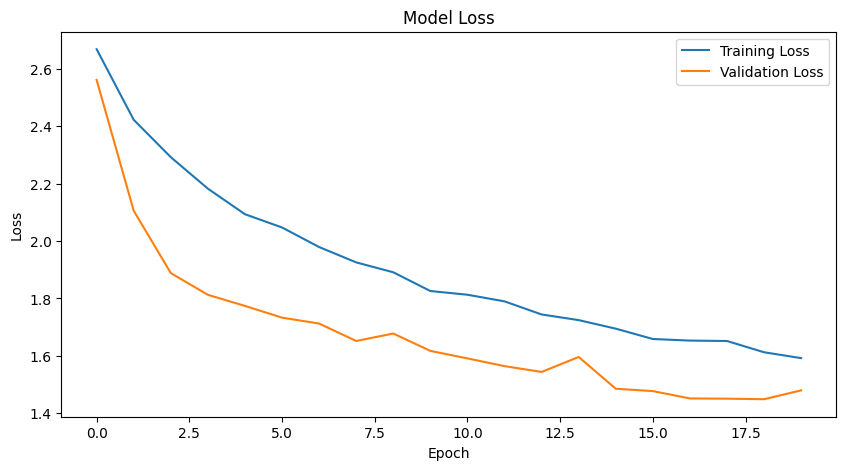

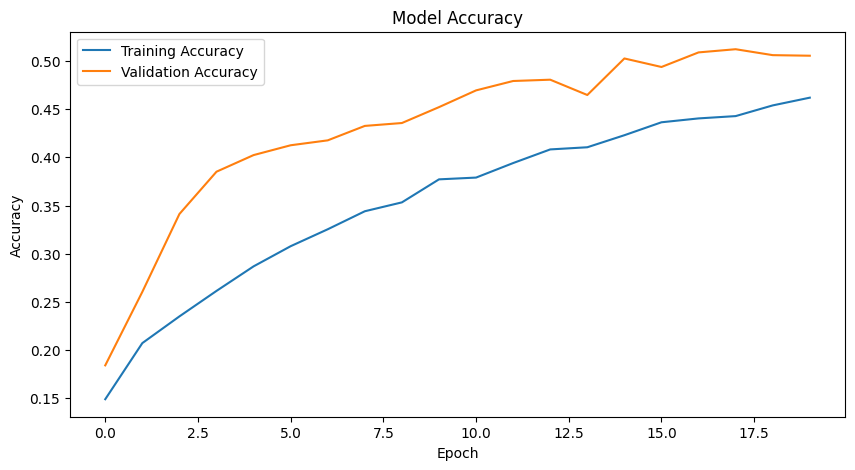

In [108]:
plt.figure(figsize=(10, 5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


## Model Evaluation

Evaluate the trained model on a separate validation set.
Compute and report metrics such as accuracy, precision, recall, and F1-score.
Visualize the confusion matrix to understand model performance across different classes

# Separate validation set

In [109]:
test_loss, test_acc = cnn_model.evaluate(val_set)
print(f"Test accuracy: {test_acc}")

105/105 [==============================] - 85s 811ms/step - loss: 1.4795 - accuracy: 0.5012
Test accuracy: 0.5011987090110779


In [110]:
test_loss, test_acc = cnn_model.evaluate(test_set)
print(f"Test accuracy: {test_acc}")

62/62 [==============================] - 7s 114ms/step - loss: 1.6592 - accuracy: 0.4579
Test accuracy: 0.4579296410083771


### Compute and report metrics such as accuracy, precision, recall, and F1-score

In [111]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score  # Add this import statement


#Get the true labels from both validation and test sets
validation_true_labels = val_set.classes
test_true_labels = test_set.classes

class_names = list(val_set.class_indices.keys())


validation_pred = cnn_model.predict(val_set)
validation_pred_labels = np.argmax(validation_pred, axis=1)

acc_val = accuracy_score(validation_true_labels, validation_pred_labels)

print(f"Validation Set - Classification report:")
print(classification_report(validation_true_labels, validation_pred_labels, target_names=class_names))
print(validation_pred_labels)




test_pred = cnn_model.predict(test_set)
test_pred_labels = np.argmax(test_pred, axis=1)

acc_test = accuracy_score(test_true_labels, test_pred_labels)


print(f"Test set - Classification report:")
print(classification_report(test_true_labels, test_pred_labels, target_names=class_names))
print(test_pred_labels)

105/105 [==============================] - 84s 802ms/step
Validation Set - Classification report:
              precision    recall  f1-score   support

        cane       0.18      0.32      0.23      1240
     cavallo       0.11      0.11      0.11       669
    elefante       0.06      0.12      0.08       369
    farfalla       0.07      0.09      0.08       538
     gallina       0.13      0.07      0.09       790
       gatto       0.00      0.00      0.00       425
       mucca       0.06      0.02      0.03       476
      pecora       0.05      0.03      0.04       464
       ragno       0.18      0.17      0.17      1229
  scoiattolo       0.08      0.06      0.07       474

    accuracy                           0.13      6674
   macro avg       0.09      0.10      0.09      6674
weighted avg       0.11      0.13      0.12      6674

[0 6 1 ... 0 0 1]
62/62 [==============================] - 7s 114ms/step
Test set - Classification report:
              precision    recall  f

# Compute the confusion matrix

### Validation Set

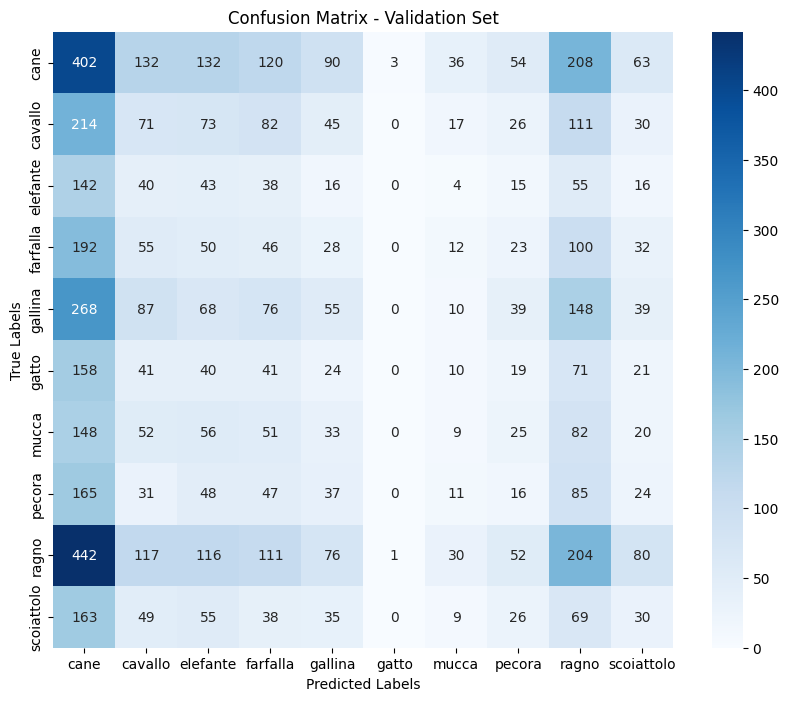

In [112]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


#Confusion matrix
conf_matrix = confusion_matrix(validation_true_labels, validation_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Validation Set')
plt.show()

### Test Set

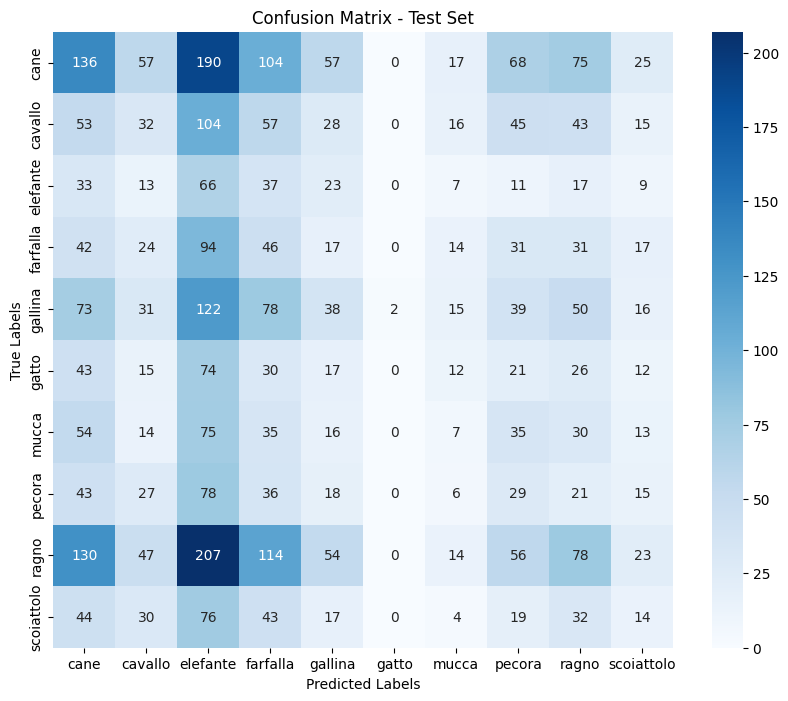

In [113]:

#Confusion matrix
conf_matrix = confusion_matrix(test_true_labels, test_pred_labels)

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix - Test Set')
plt.show()

## Transfer Learning

Evaluate the accuracy of your model on a pre-trained models like ImagNet, VGG16, Inception... (pick one an justify your choice)
Perform transfer learning with your chosen pre-trained models i.e., you will probably try a few and choose the best one.

In [114]:
# Save the trained model
cnn_model.save("original_model.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


\### Removing the first layer and performing transfer learning using pre-trained models

In [121]:
import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Load pre-trained VGG16 model
vgg_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adjust the output shape of VGG16 to match the input shape of the original model
x = Flatten()(vgg_base.output)
output_vgg = Dense(10, activation='softmax')(x)

# Create VGG model
vgg_model = Model(inputs=vgg_base.input, outputs=output_vgg)

# Load pre-trained ResNet50 model
resnet_base = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Adjust the output shape of ResNet50 to match the input shape of the original model
x = Flatten()(resnet_base.output)
output_resnet = Dense(128, activation='relu')(x)
output_resnet = Dropout(0.5)(output_resnet)
output_resnet = Dense(10, activation='softmax')(output_resnet)

# Create ResNet50 model
resnet_model = Model(inputs=resnet_base.input, outputs=output_resnet)

# Load pre-trained InceptionV3 model
inception_base = InceptionV3(weights='imagenet', include_top=False, input_shape=(299, 299, 3))

# Adjust the output shape of InceptionV3 to match the input shape of the original model
x = Flatten()(inception_base.output)
output_inception = Dense(128, activation='relu')(x)
output_inception = Dropout(0.5)(output_inception)
output_inception = Dense(10, activation='softmax')(output_inception)

# Create InceptionV3 model
inception_model = Model(inputs=inception_base.input, outputs=output_inception)

# Compile all models
for model in [vgg_model, resnet_model, inception_model]:
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy')


In [120]:
# Train the VGG model
history_VGG = vgg_model.fit(
    train_set,
    validation_data=val_set,
    epochs=10,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the VGG model
test_loss_VGG, test_acc_VGG = vgg_model.evaluate(test_set)
print(f"VGG Model Test accuracy: {test_acc_VGG}")



Epoch 1/15


InvalidArgumentError: Graph execution error:

Detected at node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits defined at (most recent call last):
  File "/usr/lib/python3.10/runpy.py", line 196, in _run_module_as_main

  File "/usr/lib/python3.10/runpy.py", line 86, in _run_code

  File "/usr/local/lib/python3.10/dist-packages/colab_kernel_launcher.py", line 37, in <module>

  File "/usr/local/lib/python3.10/dist-packages/traitlets/config/application.py", line 992, in launch_instance

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelapp.py", line 619, in start

  File "/usr/local/lib/python3.10/dist-packages/tornado/platform/asyncio.py", line 195, in start

  File "/usr/lib/python3.10/asyncio/base_events.py", line 603, in run_forever

  File "/usr/lib/python3.10/asyncio/base_events.py", line 1909, in _run_once

  File "/usr/lib/python3.10/asyncio/events.py", line 80, in _run

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 685, in <lambda>

  File "/usr/local/lib/python3.10/dist-packages/tornado/ioloop.py", line 738, in _run_callback

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 825, in inner

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 786, in run

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 361, in process_one

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 261, in dispatch_shell

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/kernelbase.py", line 539, in execute_request

  File "/usr/local/lib/python3.10/dist-packages/tornado/gen.py", line 234, in wrapper

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py", line 302, in do_execute

  File "/usr/local/lib/python3.10/dist-packages/ipykernel/zmqshell.py", line 539, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 2975, in run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3030, in _run_cell

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/async_helpers.py", line 78, in _pseudo_sync_runner

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3257, in run_cell_async

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3473, in run_ast_nodes

  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code

  File "<ipython-input-120-15b99dc8325a>", line 2, in <cell line: 2>

  File "/usr/local/lib/python3.10/dist-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1807, in fit

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1401, in train_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1384, in step_function

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1373, in run_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1151, in train_step

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py", line 1209, in compute_loss

  File "/usr/local/lib/python3.10/dist-packages/keras/src/engine/compile_utils.py", line 277, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 143, in __call__

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 270, in call

  File "/usr/local/lib/python3.10/dist-packages/keras/src/losses.py", line 2454, in sparse_categorical_crossentropy

  File "/usr/local/lib/python3.10/dist-packages/keras/src/backend.py", line 5775, in sparse_categorical_crossentropy

logits and labels must have the same first dimension, got logits shape [3211264,64] and labels shape [64]
	 [[{{node sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/SparseSoftmaxCrossEntropyWithLogits}}]] [Op:__inference_train_function_440482]

In [ ]:

# Train the ResNet50 model
history_resnet = resnet_model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the ResNet50 model
test_loss_resnet, test_acc_resnet = resnet_model.evaluate(test_set)
print(f"Resnet 50 Model Test accuracy: {test_acc_resnet}")

In [ ]:

# Train the InceptionV3 model
history_inception = inception_model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the InceptionV3 model
test_loss_inception, test_acc_inception = inception_model.evaluate(test_set)
print(f"InceptionV3 Model Test accuracy: {test_acc_inception}")


### Choose one of the previous models and fine-tune it for better results

In [ ]:
# Unfreeze some of the base model layers
for layer in VGG_model.layers[-20:]:  # Unfreeze the last 20 layers
    if not isinstance(layer, BatchNormalization):  # Optionally leave BatchNormalization layers frozen
        layer.trainable = True

# Recompile the model (necessary after changing layer trainability)
VGG_model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Continue training
history_final = VGG_model.fit(
    train_set,
    validation_data=val_set,
    epochs=15,
    callbacks=[early_stopping, reduce_lr],
    verbose=2
)

# Evaluate the model
test_loss_final, test_acc_final = VGG_model.evaluate(test_set)
print(f"Final Model Test accuracy: {test_acc_final}")


In [ ]:
# Save the model to disk

model_dir = "./model"
model_version = 1
model_export_path = f"{model_dir}/{model_version}"

tf.saved_model.save(
    VGG_model,
    export_dir=model_export_path,
)

print(f"SavedModel files: {os.listdir(model_export_path)}")